In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2024-11-11 19:19:17.525990: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-11 19:19:17.600546: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731323957.640905    1388 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731323957.652131    1388 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-11 19:19:17.724924: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [3]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [4]:
train_data = train_datagen.flow_from_directory(
    'split_dataset/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 10869 images belonging to 12 classes.


In [5]:
val_data = train_datagen.flow_from_directory(
    'split_dataset/val',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 2331 images belonging to 12 classes.


In [6]:
val_test_datagen = ImageDataGenerator(rescale=1.0/255)
test_data = val_test_datagen.flow_from_directory(
    'split_dataset/test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 2337 images belonging to 12 classes.


In [7]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout

In [8]:
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

I0000 00:00:1731323960.994482    1388 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2246 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5


In [9]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.4)(x)
predictions = Dense(train_data.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

In [10]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [11]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

In [12]:
checkpoint_callback = ModelCheckpoint(
    filepath="myModel.keras",  # ubah ekstensi dari .h5 ke .keras
    monitor="val_loss",           # metrik yang di-monitor (bisa juga 'val_accuracy')
    save_best_only=True,          # hanya menyimpan model terbaik
    mode="min"                    # 'min' jika menggunakan val_loss, 'max' jika val_accuracy
)

In [13]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, min_lr=0.00001)

In [14]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=100,
    callbacks=[early_stopping, checkpoint_callback, reduce_lr]
)

/home/arra/miniconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100


I0000 00:00:1731323963.063001    1520 service.cc:148] XLA service 0x7f723c00a590 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731323963.063136    1520 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2024-11-11 19:19:23.106149: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1731323963.338129    1520 cuda_dnn.cc:529] Loaded cuDNN version 90300
2024-11-11 19:19:26.350866: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.34GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


  1/340 ━━━━━━━━━━━━━━━━━━━━ 33:16 6s/step - accuracy: 0.0938 - loss: 2.5813

I0000 00:00:1731323967.388589    1520 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


340/340 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - accuracy: 0.6911 - loss: 1.0214

/home/arra/miniconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-11-11 19:20:58.413680: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.33GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


340/340 ━━━━━━━━━━━━━━━━━━━━ 98s 271ms/step - accuracy: 0.6914 - loss: 1.0204 - val_accuracy: 0.8807 - val_loss: 0.3545 - learning_rate: 0.0010
Epoch 2/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 80s 235ms/step - accuracy: 0.8693 - loss: 0.3818 - val_accuracy: 0.9159 - val_loss: 0.2936 - learning_rate: 0.0010
Epoch 3/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 77s 226ms/step - accuracy: 0.8931 - loss: 0.3142 - val_accuracy: 0.9146 - val_loss: 0.2679 - learning_rate: 0.0010
Epoch 4/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 78s 230ms/step - accuracy: 0.9075 - loss: 0.2666 - val_accuracy: 0.9245 - val_loss: 0.2435 - learning_rate: 0.0010
Epoch 5/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 77s 226ms/step - accuracy: 0.9203 - loss: 0.2354 - val_accuracy: 0.9288 - val_loss: 0.2302 - learning_rate: 0.0010
Epoch 6/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 78s 230ms/step - accuracy: 0.9267 - loss: 0.2166 - val_accuracy: 0.9254 - val_loss: 0.2384 - learning_rate: 0.0010
Epoch 7/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 79s 231ms/step - accuracy: 0.9284 -

In [15]:
from tensorflow.keras.models import load_model

# Memuat model terbaik
best_model = load_model("myModel.keras")

In [16]:
test_loss, test_accuracy = best_model.evaluate(test_data)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

74/74 ━━━━━━━━━━━━━━━━━━━━ 7s 77ms/step - accuracy: 0.9499 - loss: 0.1491
Test Accuracy: 94.27%


In [17]:
best_model.save('myModel.keras')

In [1]:
best_model.summary()

NameError: name 'best_model' is not defined

In [18]:
import matplotlib.pyplot as plt

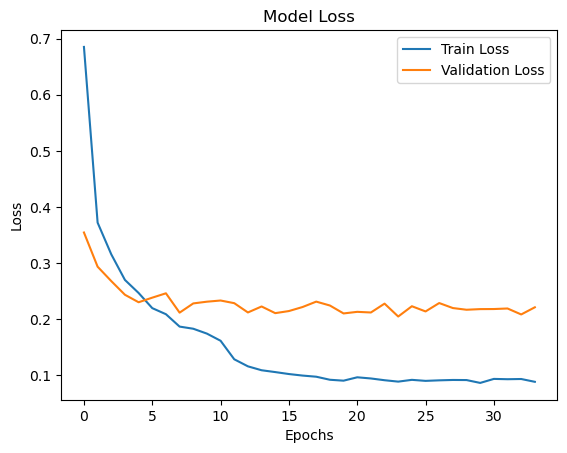

In [19]:
# Plot Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()
plt.show()

In [21]:
plt.savefig("model_loss.png", dpi=300, bbox_inches='tight', transparent=True)

<Figure size 640x480 with 0 Axes>

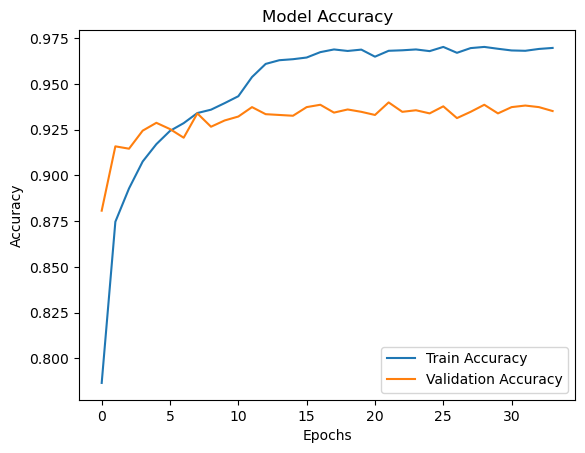

In [20]:
# Plot Akurasi
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()
plt.show()

In [22]:
plt.savefig("modell_accuracy.png", dpi=300, bbox_inches='tight', transparent=True)

<Figure size 640x480 with 0 Axes>